## DQ Echo pulses
- first sq echo
- second is dq echo


In [2]:
import qutip as qt
import numpy as np
import scipy.fftpack as fftpack
#from detecta import detect_peaks
from scipy.optimize import curve_fit
import pickle
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import scipy.stats as stats

from detecta import detect_peaks

#this function returns the single NV center hamiltonian
def h_NV_Single(h0, d_param=2870, gamma = 28025):
    return d_param*2*np.pi*qt.spin_Jz(1)**2 + 2*np.pi*(gamma*h0)*qt.spin_Jz(1)

#this function outputs a sign wave.
# takes in some arguments as a dictionary
# h1 is the power (amplitude) of the sin wave
# wrf is the frequency (use that to select transition)
# phi is the phase (good for phase cycling)
# t_start and t_duration are for the start and stop times of the pulse, i use a heaviside step function to make this work
# --- play with these parameters and plot them to see how it works----
def mw_sin_pulse_coeff(t, args):
    h1 = args['h1']
    wrf = args['wrf']
    phi = args['phi']
    t_start = args['t_start']
    t_duration = args['t_duration']
    return h1* np.sin(2*np.pi*wrf* (t-t_start) + phi)* (np.heaviside(t - t_start, 1)*(1-np.heaviside(t-(t_start+t_duration),1)))

#implenting the mw_sin_pulse_coeff function with specific args so that we have a "ramsey pulse" -- just 2 t90 pulses separated by soem spacing
def ramsey_pulse_coef(t, args):
    h1 = args['h1']
    wrf = args["wrf"]
    t_spacing = args["t_spacing"]
    phi1 = args['phi1']
    phi2 = args['phi2']
    #t90 = args['t90']
    t90 = np.pi/(np.sqrt(2)*h1) #if you know the power of your pulse then this is your theoretical t90
    pulse1 = {'h1':h1,'wrf':wrf,"phi":phi1,"t_duration":t90,"t_start":0}
    pulse2 = {'h1':h1,'wrf':wrf,"phi":phi2,"t_duration":t90,"t_start":t90+t_spacing}

    return mw_sin_pulse_coeff(t, pulse1) + mw_sin_pulse_coeff(t, pulse2)

#same as mw_sin_pulse_coeff but for two frequencies together
def mw_sin_twotone_pulse_coeff(t, args):
    h1 = args['h1']
    wrf1 = args['wrf1']
    wrf2 = args['wrf2']
    phi1 = args['phi1']
    phi2 = args['phi2']
    t_start = args['t_start']
    t_duration = args['t_duration']
    return h1* (np.sin(wrf1* (t-t_start) + phi1) + np.sin(wrf2* (t-t_start) + phi2))* (np.heaviside(t - t_start, 1)*(1-np.heaviside(t-(t_start+t_duration),1)))

#same as remasey_pulse_coef but for two frequencies
def ramsey_twotone_pulse_coeff(t, args):
    h1 = args['h1']
    wrf1 = args["wrf1"]
    wrf2 = args["wrf2"]
    t_spacing = args["t_spacing"]
    phi11 = args['phi11'] #phase of pulse channel 1 first
    phi12 = args['phi12'] #phase of pulse channel 1 second
    phi21 = args['phi21'] #phase of pulse channel 2 first
    phi22 = args['phi22'] #phase of pulse channel 2 second
    t90 = np.pi/(h1)
    pulse11 = {'h1':h1,'wrf':wrf1,"phi":phi11,"t_duration":t90,"t_start":0}
    pulse12 = {'h1':h1,'wrf':wrf1,"phi":phi12,"t_duration":t90,"t_start":t90+t_spacing}
    pulse21 = {'h1':h1,'wrf':wrf2,"phi":phi21,"t_duration":t90,"t_start":0}
    pulse22 = {'h1':h1,'wrf':wrf2,"phi":phi22,"t_duration":t90,"t_start":t90+t_spacing}
    return mw_sin_pulse_coeff(t, pulse11) + mw_sin_pulse_coeff(t, pulse12) + mw_sin_pulse_coeff(t, pulse21) + mw_sin_pulse_coeff(t, pulse22)

def sq_echo_pulse(t, args):
    h1 = args['h1']
    wrf = args['wrf']
    phi1 = args['phi']
    echo_t1 = args['echo_t1']
    echo_t2 = args['echo_t2']
    # t_start = args['t_start']
    # t_duration = args['t_duration']
    t90 = args['t90']
        
    pulse1 = {'h1':h1, 'wrf':wrf, 'phi':phi1, 't_start':0, 't_duration':t90}
    pulse2 = {'h1':h1, 'wrf':wrf, 'phi':phi1, 't_start':t90+echo_t1, 't_duration':2*t90}
    pulse3 = {'h1':h1, 'wrf':wrf, 'phi':phi1, 't_start':3*t90+echo_t1+echo_t2, 't_duration':t90}
    return mw_sin_pulse_coeff(t, pulse1) + mw_sin_pulse_coeff(t, pulse2) + mw_sin_pulse_coeff(t, pulse3)
   
def dq_echo_pulse(t, args): #should be similar to sq_echo_pulse function above, just with mw_twotone_pulse_coeff() being used.
    h1 = args['h1']
    wrf1 = args['wrf1']
    wrf2 = args['wrf2']
    phi1 = args['phi1']
    phi2 = args['phi2']
    echo_t1 = args['echo_t1']
    echo_t2 = args['echo_t2']
    t90 = args['t90']
    #still will have 3 pulses, but the pulses wll be using a different function
    pulse1 = {'h1':h1, 'wrf1':wrf1, 'wrf2':wrf2, 'phi1':phi1, 'phi2':phi2, 't_start':0, 't_duration':t90}
    pulse2 = {'h1':h1, 'wrf1':wrf1, 'wrf2':wrf2, 'phi1':phi1, 'phi2':phi2, 't_start':t90+echo_t1, 't_duration':2*t90}
    pulse3 = {'h1':h1, 'wrf1':wrf1, 'wrf2':wrf2, 'phi1':phi1, 'phi2':phi2, 't_start':3*t90+echo_t1+echo_t2, 't_duration':t90}
    #return the final pulse, sum of all three twotone pulses
    return mw_sin_twotone_pulse_coeff(t, pulse1) + mw_sin_twotone_pulse_coeff(t, pulse2) + mw_sin_twotone_pulse_coeff(t, pulse3)



"""some helper functions below that do specific things"""
def complexabs(input): #just a complex abs value function
    return np.conjugate(input)*input

def fourier_transform(xlist, ylist):
    yf = fft(ylist)
    xf = fftfreq(len(xlist), xlist[1]-xlist[0])
    yffinal = np.fft.fftshift(yf)
    xffinal = np.fft.fftshift(xf)
    # return xffinal, np.abs(yffinal)
    return np.array([xffinal, yffinal])

def fourier_transform1(ylist, dt):
    ftransform = np.abs(fftpack.rfft(np.asarray(ylist, dtype=float)))
    freqs = fftpack.rfftfreq(len(ylist), d=dt)
    return freqs, np.abs(ftransform)
    

### SQ echo

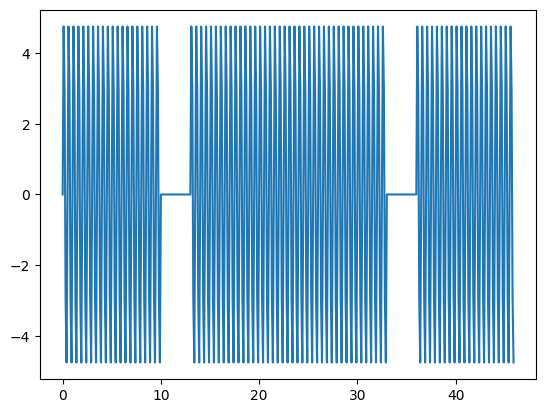

In [3]:
#t90 = np.pi/h1
t90 = 10 
phi = 0
wrf = 2
echo_t2 = 3 #np.arange(0.01, 0.05, 0.005)
echo_t1 = 3
echo_time = np.arange(0,4*t90+echo_t1+echo_t2, 0.1)

psi0 = qt.basis(3,1)
d = 2870
gamma = 28025
h0 = 870/gamma
wrf1 = d-gamma*h0
wrf2 = d+gamma*h0
#h1 = 47

# #pulse1 = {'h1':h1, 'wrf':wrf, 'phi':phi, 't_start':0, 't_duration':t90}
# #pulse2 = {'h1':h1, 'wrf':wrf, 'phi':phi, 't_start':t90 + echo_t1, 't_duration':t180}
# #pulse3 = {'h1':h1, 'wrf':wrf, 'phi':phi, 't_start':3*t90+t1+echo_t2, 't_duration':t90}
# pulseargs = {'pulse1', 'pulse2', 'pulse3'}
sq_echo_args = {'h1':5, 'wrf':wrf, 'phi':phi, 'echo_t1':echo_t1 ,'echo_t2':echo_t2 ,'t90':t90}
plt.plot(echo_time, sq_echo_pulse(echo_time, sq_echo_args))


### $T_{2}$ echo sweep

In [4]:

h1=5
t90 = np.pi/(np.sqrt(2)*h1)
phi = 0
echo_t2 = np.linspace(0.001, 0.01, 256)
echo_t1 = 0.005
print(len(echo_t2))
psi0 = qt.basis(3,1)
d = 2870
gamma = 28025
h0 = 870/gamma
wrf1 = d-gamma*h0
wrf2 = d+gamma*h0
echolist = []
c = 0
for i in echo_t2:
    sq_echo_args = {'h1':h1,'wrf':wrf1,'phi':phi,'echo_t1':echo_t1,'echo_t2':i,'t90':t90}
    echo_time = np.arange(0,4*t90+echo_t1+i, 0.0001)
    Hamtot = [h_NV_Single(h0), [qt.spin_Jx(1), sq_echo_pulse]]
    res = qt.mesolve(Hamtot, psi0, echo_time, [], [], args=sq_echo_args, progress_bar=True) 
    print('step ' + str(c) + ' out of ' + str(len(echo_t2)) + ' completed')
    midel = (res.states[-1].dag()*qt.basis(3,1))[0][0][0]
    echolist.append(np.conjugate(midel)*midel)
    c += 1


256
10.0%. Run time:   0.63s. Est. time left: 00:00:00:05
20.0%. Run time:   1.25s. Est. time left: 00:00:00:04
30.0%. Run time:   1.87s. Est. time left: 00:00:00:04
40.0%. Run time:   2.52s. Est. time left: 00:00:00:03
50.0%. Run time:   3.13s. Est. time left: 00:00:00:03
60.0%. Run time:   3.75s. Est. time left: 00:00:00:02
70.0%. Run time:   4.37s. Est. time left: 00:00:00:01
80.0%. Run time:   4.98s. Est. time left: 00:00:00:01
90.0%. Run time:   5.61s. Est. time left: 00:00:00:00
Total run time:   6.23s
step 0 out of 256 completed
10.0%. Run time:   0.61s. Est. time left: 00:00:00:05
20.0%. Run time:   1.22s. Est. time left: 00:00:00:04
30.0%. Run time:   1.83s. Est. time left: 00:00:00:04
40.0%. Run time:   2.45s. Est. time left: 00:00:00:03
50.0%. Run time:   3.10s. Est. time left: 00:00:00:03
60.0%. Run time:   3.72s. Est. time left: 00:00:00:02
70.0%. Run time:   4.34s. Est. time left: 00:00:00:01
80.0%. Run time:   4.95s. Est. time left: 00:00:00:01
90.0%. Run time:   5.56s. 

### sq sim plot

In [4]:
plt.plot(echo_t2, echolist - np.mean(echolist), label='sq echo')
plt.xlabel(r'$t_{2}$ sweep')
plt.legend()
plt.grid()

NameError: name 'echolist' is not defined

### sq sim fft

(-3000.0, 3000.0)

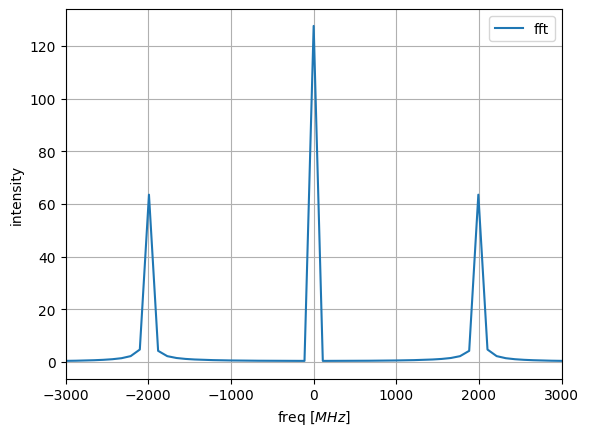

In [6]:
sq_echo_fft = fourier_transform(echo_t2, echolist)

sq_echo_x = sq_echo_fft[0,:]
sq_echo_y = np.abs(sq_echo_fft[1,:])

plt.plot(sq_echo_x, sq_echo_y, label='fft')
plt.xlabel(r'freq $[MHz]$')
plt.ylabel(r'intensity')
plt.grid(), plt.legend()
plt.xlim(-3000,3000)

### Now for the dq sims 
#### first the pulse, then the overall system sim, then plotting and fft

4.442882938158366


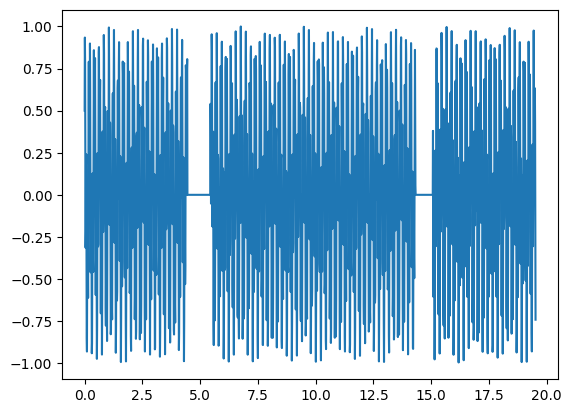

In [47]:
## first need to establish the parameters listed in the function in cell [1]
"""
def dq_echo_pulse(t, args): #should be similar to sq_echo_pulse function above, just with ramsey_twotone_pulse_coeff() being used.
    h1 = args['h1']
    wrf1 = args['wrf1']
    wrf2 = args['wrf2']
    phi1 = args['phi1']
    phi2 = args['phi2']
    echo_t1 = args['echo_t1']
    echo_t2 = args['echo_t2']
    t90 = args['t90']
    #still will have 3 pulses, but the pulses wll be using a different function
    pulse1 = {'h1':h1, 'wrf1':wrf1, 'wrf2':wrf2, 'phi1':phi1, 'phi2':phi2, 't_start':0, 't_duration':t90}
    pulse2 = {'h1':h1, 'wrf1':wrf1, 'wrf2':wrf2, 'phi1':phi1, 'phi2':phi2, 't_start':t90+echo_t1, 't_duration':2*t90}
    pulse3 = {'h1':h1, 'wrf1':wrf1, 'wrf2':wrf2, 'phi1':phi1, 'phi2':phi2, 't_start':2*t90+echo_t1+echo_t2, 't_duration':t90}
    #return the final pulse, sum of all three twotone pulses
    return mw_sin_twotone_pulse_coeff(t, pulse1) + mw_sin_twotone_pulse_coeff(t, pulse2) + mw_sin_twotone_pulse_coeff(t, pulse3)
"""
psi0 = qt.basis(3,1)
d = 2870
gamma = 28025
h0 = 870/gamma
#wrf1 = d-gamma*h0
#wrf2 = d+gamma*h0
echolist = []

h1 = .5
wrf1 = d - gamma*h0
wrf2 = d + gamma*h0
phi1 = 0
phi2 = np.pi/2
echo_t1 = 1
echo_t2 = 0.75
t90 = np.pi/(np.sqrt(2)*h1)
print(t90)
echo_time = np.arange(0, 4*t90+echo_t1+echo_t2, 0.01)

dq_echo_args = {'h1':h1, 'wrf1':wrf1, 'wrf2':wrf2, 'phi1':phi1, 'phi2':phi2, 'echo_t1':echo_t1, 'echo_t2':echo_t2, 't90':t90}

plt.plot(echo_time, dq_echo_pulse(echo_time, dq_echo_args))
#looks rough... will return to this later

### $t_{2}$ dq echo sweep


In [48]:
dq_echolist = []
c = 0
echo_t2 = np.linspace(0.001, 0.01, 128)
for i in echo_t2:
    dq_echo_args = {'h1':h1, 'wrf1':wrf1, 'wrf2':wrf2, 'phi1':phi1, 'phi2':phi2, 'echo_t1':echo_t1, 'echo_t2':i, 't90':t90}
    echo_time = np.arange(0,4*t90+echo_t1+i, 0.0001)
    Hamtot = [h_NV_Single(h0), [qt.spin_Jx(1), dq_echo_pulse]]
    res = qt.mesolve(Hamtot, psi0, echo_time, [], [], args=dq_echo_args, progress_bar=True) 
    print('step ' + str(c) + ' out of ' + str(len(echo_t2)) + ' completed')
    midel = (res.states[-1].dag()*qt.basis(3,1))[0][0][0]
    dq_echolist.append(np.conjugate(midel)*midel)
    c += 1




10.0%. Run time:   7.27s. Est. time left: 00:00:01:05
20.0%. Run time:  15.20s. Est. time left: 00:00:01:00
30.0%. Run time:  23.29s. Est. time left: 00:00:00:54
40.0%. Run time:  31.24s. Est. time left: 00:00:00:46
50.0%. Run time:  39.29s. Est. time left: 00:00:00:39
60.0%. Run time:  47.63s. Est. time left: 00:00:00:31
70.0%. Run time:  55.87s. Est. time left: 00:00:00:23
80.0%. Run time:  63.86s. Est. time left: 00:00:00:15
90.0%. Run time:  72.06s. Est. time left: 00:00:00:08
Total run time:  80.05s
step 0 out of 128 completed
10.0%. Run time:   6.99s. Est. time left: 00:00:01:02
20.0%. Run time:  14.98s. Est. time left: 00:00:00:59
30.0%. Run time:  23.17s. Est. time left: 00:00:00:54
40.0%. Run time:  31.19s. Est. time left: 00:00:00:46
50.0%. Run time:  39.21s. Est. time left: 00:00:00:39
60.0%. Run time:  47.29s. Est. time left: 00:00:00:31
70.0%. Run time:  55.52s. Est. time left: 00:00:00:23
80.0%. Run time:  63.63s. Est. time left: 00:00:00:15
90.0%. Run time:  71.71s. Est.

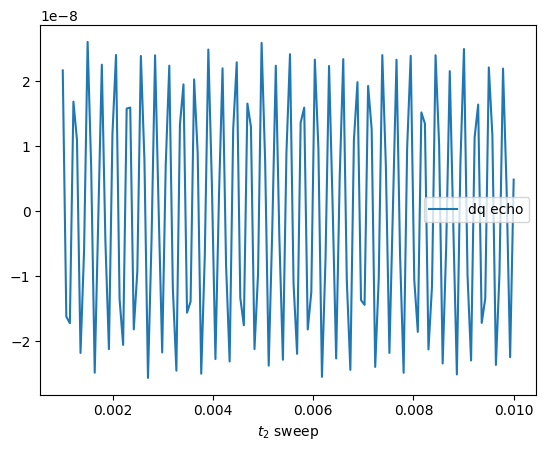

In [ ]:
plt.plot(echo_t2, dq_echolist - np.mean(dq_echolist), label='dq echo')
plt.xlabel(r'$t_2$ sweep')
plt.legend()

### dq echo fft

In [32]:
dq_echo_fft = fourier_transform(echo_t2, dq_echolist)

dq_echo_x = dq_echo_fft[0,:]
dq_echo_y = np.abs(dq_echo_fft[1,:] - np.mean(dq_echo_fft[1,:]))

plt.plot(dq_echo_x, dq_echo_y, label='fft')
plt.xlabel(r'freq $[MHz]$')
plt.ylabel(r'intensity')
plt.grid(), plt.legend()
plt.xlim(-3000,3000)

NameError: name 'echo_t2' is not defined

### introducing the hyperfine coupling term

1. create a new hamiltonian similar to the one defined in cell [1] with additional terms

hamiltonian w/o hyperfine coupling term:
$H = D\hat{S}_{z}^{2} + 2 \pi \gamma h_{0} \hat{S}_{z}$

where $\hat{S}_{z}$ is represented by the qutip function spin_Jz

the hamiltonian that we want has two additional terms: $\hat{H}_{1}(t) \hat{S}_{x}$ and 

$\vec{I}_{1} \cdot \hat{A} \cdot \vec{S}_{NV}$ = $D\hat{S}_{z}^{2} \otimes \bold{I} + 2 \pi \gamma h_{0} \hat{S}_{z} \otimes \bold{I} + H_{1}(t) \hat{S}_{x} \otimes \mathbb{I} + A_{\parallel} \hat{S}_{z} \otimes \mathbb{I}_{z} + A_{\perp} (\hat{S}_{x} \otimes \mathbb{I}_{x} + \hat{S}_{y} \otimes \mathbb{I}_{y})$

#### So the full hamiltonian is 
$H = D*2\pi \hat{S}_{z}^{2}\otimes \mathbb{I} + 2 \pi \gamma h_{0} \hat{S}_{z} \otimes \mathbb{I} +   H_{1}(t) \hat{S}_{x} \otimes \mathbb{I} + A_{\parallel} \hat{S}_{z} \otimes \mathbb{I}_{z} + A_{\perp} (\hat{S}_{x} \otimes \mathbb{I}_{x} + \hat{S}_{y} \otimes \mathbb{I}_{y})$


In [5]:
## original function: 

"""
def h_NV_Single(h0, d_param=2870, gamma = 28025):
    return d_param*2*np.pi*qt.spin_Jz(1)**2 + 2*np.pi*(gamma*h0)*qt.spin_Jz(1)
 """


def h_NV_full(h0, d_param=2870 , gamma=28025): #both in MHz
    
    Apar = 214 #MHz, was originally 2.14 MHz
    Aperp = 0 #2.7 #MHz
    gamma_e = gamma #see above param gamma
    electron_spin_ham = d_param*2*np.pi * qt.tensor(qt.spin_Jz(1)**2, qt.qeye(3)) + 2*np.pi*gamma*h0 * qt.tensor(qt.spin_Jz(1), qt.qeye(3))
    #nuclear_spin_ham = return to this with a time-dependent hamiltonian
    spin_interaction_ham = 2*np.pi*(Apar * qt.tensor(qt.spin_Jz(1), qt.spin_Jz(1))) #+ Aperp*(qt.tensor(qt.spin_Jx(1), qt.spin_Jx(1)) + qt.tensor(qt.spin_Jy(1), qt.spin_Jy(1)))
    
    return electron_spin_ham + spin_interaction_ham
    
print(np.shape(h_NV_full(870/28025)))
print(h_NV_full(870/28025))

(9, 9)
Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[24843.71470459     0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.         23499.11304885     0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.         22154.51139312     0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.             0.         11221.76895862     0.
      0.        ]
 [    0.       

### perform sq ramsey with modified hamiltonian

In [98]:
"""
def ramsey_pulse_coef(t, args):
    h1 = args['h1']
    wrf = args["wrf"]
    t_spacing = args["t_spacing"]
    phi1 = args['phi1']
    phi2 = args['phi2']
    #t90 = args['t90']
    t90 = np.pi/(np.sqrt(2)*h1) #if you know the power of your pulse then this is your theoretical t90
    pulse1 = {'h1':h1,'wrf':wrf,"phi":phi1,"t_duration":t90,"t_start":0}
    pulse2 = {'h1':h1,'wrf':wrf,"phi":phi2,"t_duration":t90,"t_start":t90+t_spacing}

    return mw_sin_pulse_coeff(t, pulse1) + mw_sin_pulse_coeff(t, pulse2)
"""

sqr_args = {'h1':47, 'wrf':2000, 't_spacing':0.25, 'phi1':0, 'phi2':np.pi/2}
sqr_list = []
sqr_time = np.linspace(0, 1, 256)
h1=47
t90 = np.pi/(np.sqrt(2)*h1)
count = 0
psi_NV = qt.basis(3, 1)
psi_N = qt.Qobj([[1],[1],[1]])/np.sqrt(3)
for i in sqr_time:
    sqr_args = {'h1':h1, 'wrf':2000, 't_spacing':i, 'phi1':np.pi/2, 'phi2':-np.pi/2}
    tlist = np.arange(0, 2*t90+i, 0.00001)
    Hamtot = [h_NV_full(870/28025, d_param=2870, gamma=28025), [qt.tensor(qt.spin_Jx(1), qt.qeye(3)), ramsey_pulse_coef]]
    print(type(Hamtot))
    res = qt.mesolve(Hamtot, qt.tensor(psi_NV, psi_N), tlist, [], [], args=sqr_args, progress_bar=True)
    print('step '+ str(count)+' out of '+str(len(sqr_time))+' complete')
    midel = (res.states[-1].dag()*qt.tensor(psi_NV, psi_N))[0][0][0]
    sqr_list.append(np.conjugate(midel)*midel)
    count += 1



<class 'list'>
10.0%. Run time:   0.18s. Est. time left: 00:00:00:01
20.0%. Run time:   0.36s. Est. time left: 00:00:00:01
30.0%. Run time:   0.54s. Est. time left: 00:00:00:01
40.0%. Run time:   0.73s. Est. time left: 00:00:00:01
50.0%. Run time:   0.91s. Est. time left: 00:00:00:00
60.0%. Run time:   1.09s. Est. time left: 00:00:00:00
70.0%. Run time:   1.26s. Est. time left: 00:00:00:00
80.0%. Run time:   1.44s. Est. time left: 00:00:00:00
90.0%. Run time:   1.62s. Est. time left: 00:00:00:00
Total run time:   1.80s
step 0 out of 256 complete
<class 'list'>
10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.34s. Est. time left: 00:00:00:01
30.0%. Run time:   0.51s. Est. time left: 00:00:00:01
40.0%. Run time:   0.68s. Est. time left: 00:00:00:01
50.0%. Run time:   0.85s. Est. time left: 00:00:00:00
60.0%. Run time:   1.02s. Est. time left: 00:00:00:00
70.0%. Run time:   1.19s. Est. time left: 00:00:00:00
80.0%. Run time:   1.36s. Est. time left: 00:00:00:00
9

### For the fft plots, it might be more useful if we plot the fft of the mean-substracted data instead of the raw data. 


/Users/waltermendoza/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


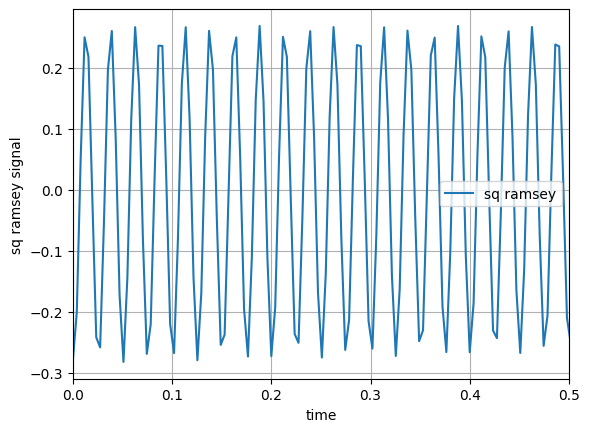

In [100]:
# now plot the actual results

plt.plot(sqr_time, sqr_list - np.mean(sqr_list), label='sq ramsey')
plt.xlabel('time')
plt.ylabel('sq ramsey signal')
plt.grid()
plt.legend()
plt.xlim(0,0.5)
plt.show()


In [1]:
ffts = fourier_transform(sqr_time, sqr_list - np.mean(sqr_list))
sq_ramseys_x = ffts[0,:]
sq_ramseys_y = ffts[1,:]
sq_ramseys_y_mean = sq_ramseys_y - np.mean(sq_ramseys_y)
plt.plot(sq_ramseys_x, np.abs(sq_ramseys_y))
plt.grid()
plt.xlabel(r'frequency, $MHz$')
plt.ylabel('')

peaks = np.array(detect_peaks(np.abs(sq_ramseys_y), show=True )) #mph=1


NameError: name 'fourier_transform' is not defined

In [102]:
print(peaks)

ramsey_peaks = np.array([sq_ramseys_y[2], sq_ramseys_y[6], sq_ramseys_y[47], sq_ramseys_y[88], sq_ramseys_y[127], 
                         sq_ramseys_y[129], sq_ramseys_y[168], sq_ramseys_y[209], sq_ramseys_y[250], sq_ramseys_y[254]])
print(ramsey_peaks)

[  1  39  47  88 127 129 168 209 217]
[ 7.14792042e-03-6.43093473e-03j  9.57607369e-03-4.86410427e-03j
  4.65022880e-02-5.76350607e-02j -3.12737698e+01+1.01396453e+01j
 -2.93984294e-01-6.91069391e-01j -2.93984294e-01+6.91069391e-01j
 -3.12737698e+01-1.01396453e+01j  4.65022880e-02+5.76350607e-02j
  9.57607369e-03+4.86410427e-03j  7.14792042e-03+6.43093473e-03j]


In [103]:
dist_between_peaks = np.abs(ramsey_peaks[6] - peaks[3])
print(dist_between_peaks)

119.70398722696731


### DQ ramsey 

In [44]:

""" 
def ramsey_twotone_pulse_coeff(t, args):
    h1 = args['h1']
    wrf1 = args["wrf1"]
    wrf2 = args["wrf2"]
    t_spacing = args["t_spacing"]
    phi11 = args['phi11'] #phase of pulse channel 1 first
    phi12 = args['phi12'] #phase of pulse channel 1 second
    phi21 = args['phi21'] #phase of pulse channel 2 first
    phi22 = args['phi22'] #phase of pulse channel 2 second
    t90 = np.pi/(h1)
    pulse11 = {'h1':h1,'wrf':wrf1,"phi":phi11,"t_duration":t90,"t_start":0}
    pulse12 = {'h1':h1,'wrf':wrf1,"phi":phi12,"t_duration":t90,"t_start":t90+t_spacing}
    pulse21 = {'h1':h1,'wrf':wrf2,"phi":phi21,"t_duration":t90,"t_start":0}
    pulse22 = {'h1':h1,'wrf':wrf2,"phi":phi22,"t_duration":t90,"t_start":t90+t_spacing}
    return mw_sin_pulse_coeff(t, pulse11) + mw_sin_pulse_coeff(t, pulse12) + mw_sin_pulse_coeff(t, pulse21) + mw_sin_pulse_coeff(t, pulse22)
"""

###create a function that uses these pulses to run the interaction simulation with the NV center
### first run a short one -- 32 steps and with a short time scale 
DQR_h1 = 47
DQR_wrf1 = d - gamma*h0
DQR_wrf2 = d + gamma*h0
DQR_t_spacing = 0.001
DQR_phi11 = 0
DQR_phi12 = 0
DQR_phi21 = 0
DQR_phi22 = 0
DQR_args = {'h1':DQR_h1, 'wrf1':DQR_wrf1, 'wrf2':DQR_wrf2, 't_spacing':DQR_t_spacing, 'phi11':DQR_phi11, 
                  'phi12':DQR_phi12, 'phi21':DQR_phi21, 'phi22':DQR_phi22}

t90 = np.pi/(np.sqrt(2)*DQR_h1)


In [46]:
DQR_time = np.linspace(0, 0.1, 128)
DQR_list = []

psi_NV = qt.basis(3, 1)
psi_N = qt.Qobj([[1],[1],[1]])/np.sqrt(3)

count = 0
for i in DQR_time:
    DQR_args = {'h1':DQR_h1, 'wrf1':DQR_wrf1, 'wrf2':DQR_wrf2, 't_spacing':i, 'phi11':DQR_phi11, 
                  'phi12':DQR_phi12, 'phi21':DQR_phi21, 'phi22':DQR_phi22}
    tlist = np.arange(0, 2*t90+i, 0.00001)
    Hamtot = [h_NV_full(h0=47, d_param=2870, gamma=28025), [qt.tensor(qt.spin_Jx(1), qt.qeye(3)), ramsey_twotone_pulse_coeff]]
    res = qt.mesolve(Hamtot, qt.tensor(psi_NV, psi_N), tlist, [], [], args=DQR_args, progress_bar=True)
    print('step '+ str(count) + ' out of ' + str(len(DQR_time)) + ' complete')
    midel = (res.states[-1].dag()*qt.tensor(psi_NV, psi_N))[0][0][0]
    DQR_list.append(np.conjugate(midel)*midel)
    count += 1



10.0%. Run time:   1.67s. Est. time left: 00:00:00:15
20.0%. Run time:   3.35s. Est. time left: 00:00:00:13
30.0%. Run time:   5.00s. Est. time left: 00:00:00:11
40.0%. Run time:   6.65s. Est. time left: 00:00:00:09
50.0%. Run time:   8.30s. Est. time left: 00:00:00:08
60.0%. Run time:   9.95s. Est. time left: 00:00:00:06
70.0%. Run time:  11.61s. Est. time left: 00:00:00:04
80.0%. Run time:  16.61s. Est. time left: 00:00:00:04
90.0%. Run time:  21.88s. Est. time left: 00:00:00:02
Total run time:  27.15s
step 0 out of 256 complete
10.0%. Run time:   1.69s. Est. time left: 00:00:00:15
20.0%. Run time:   3.39s. Est. time left: 00:00:00:13
30.0%. Run time:   5.15s. Est. time left: 00:00:00:12
40.0%. Run time:   6.85s. Est. time left: 00:00:00:10
50.0%. Run time:   8.54s. Est. time left: 00:00:00:08
60.0%. Run time:  10.24s. Est. time left: 00:00:00:06
70.0%. Run time:  12.57s. Est. time left: 00:00:00:05
80.0%. Run time:  18.01s. Est. time left: 00:00:00:04
90.0%. Run time:  23.45s. Est. 

/Users/waltermendoza/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


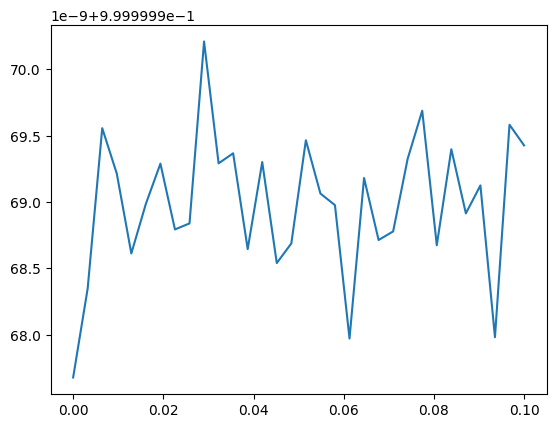

In [50]:
plt.plot(DQR_time, DQR_list)

